In [9]:
#from tifffile import imsave, imread

##%%GPU memory prepare
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
 
#from tifffile import imsave, imread

##%%GPU memory prepare
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
 
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import os
import numpy as np


# Imports (unchanged)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
import numpy as np

def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


C:\Users\yildi\miniconda3\envs\py309\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


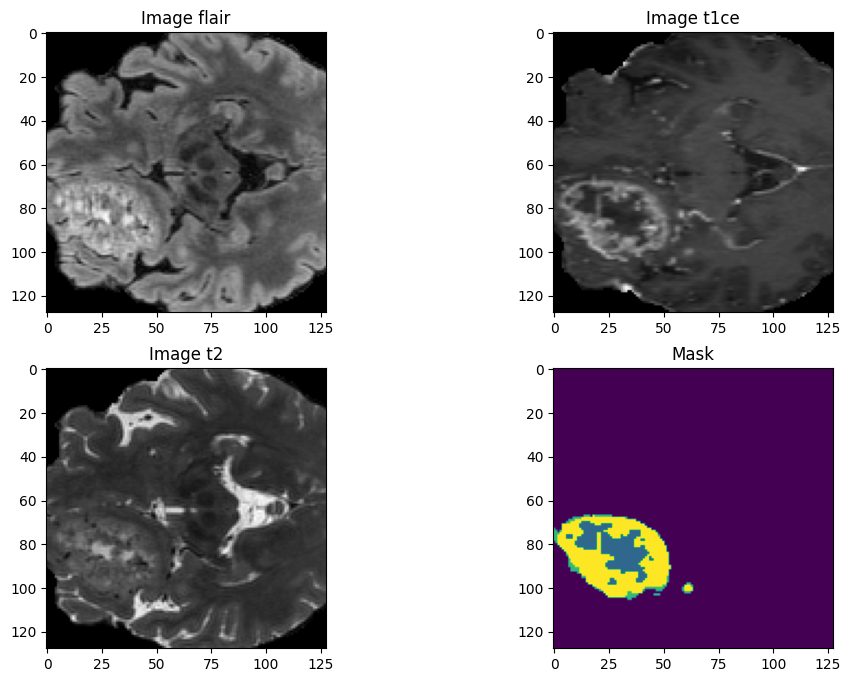

In [10]:
from matplotlib import pyplot as plt
import random

train_img_dir = "BraTask_TrainingData/images/"
train_mask_dir = "BraTask_TrainingData/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)






img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [44]:
train_img_dir = "BraTask_TrainingData/images/"
train_mask_dir = "BraTask_TrainingData/masks/"

val_img_dir = "BraTask_ValidationData/images/"
val_mask_dir = "BraTask_ValidationData/masks/"

train_img_list=os.listdir(train_img_dir)[:400]
train_mask_list = os.listdir(train_mask_dir)[:400]

val_img_list=os.listdir(val_img_dir)[:100]
val_mask_list = os.listdir(val_mask_dir)[:100]

(4, 128, 128, 128, 3)


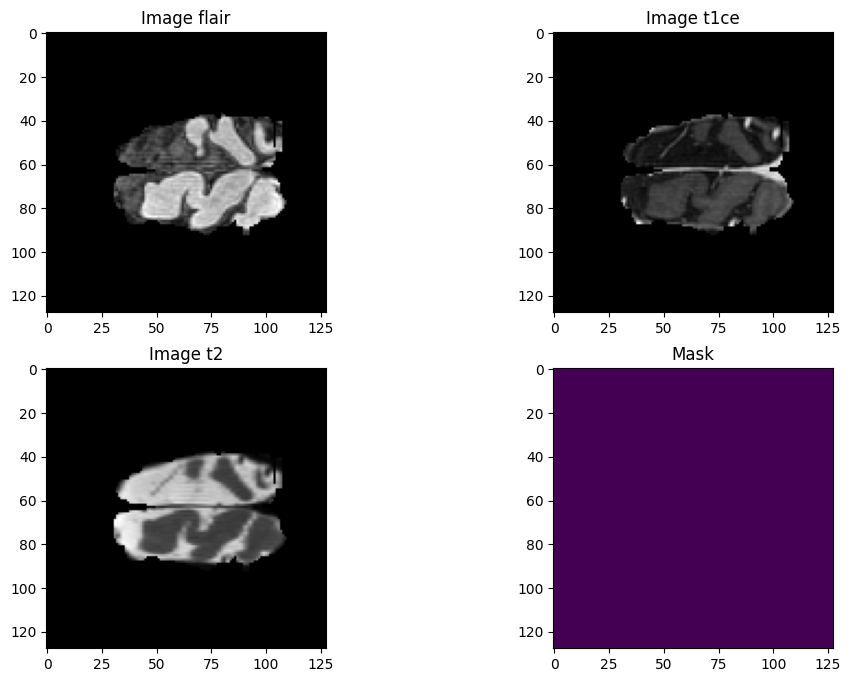

In [43]:


#Verify generator.... In python 3 next() is renamed as __next__()


print(img.shape)

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [45]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

import glob
import random
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

batch_size = 16

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

img, msk = train_img_datagen.__next__()


# Eğitim ve doğrulama adımlarını hesapla
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

print(len(train_img_list))
print(len(val_img_list))

print(steps_per_epoch)
print(val_steps_per_epoch)

# TensorFlow'un GPU kullanımını etkinleştirme
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Fiziksel cihazları listele
physical_devices = tf.config.experimental.list_physical_devices('GPU')

# Fiziksel cihazları göster
if physical_devices:
    for gpu in physical_devices:
        print("Device name:", gpu.name)
        print("Device type:", gpu.device_type)
else:
    print("No GPU available")


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


400
100
25
6
Device name: /physical_device:GPU:0
Device type: GPU
Num GPUs Available:  1


In [46]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: 
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))
    
import tensorflow as tf

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[0,:,:,:,1])) + tf.reduce_sum(tf.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[0,:,:,:,2])) + tf.reduce_sum(tf.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[0,:,:,:,3])) + tf.reduce_sum(tf.square(y_pred[0,:,:,:,3])) + epsilon)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [47]:
tf.config.run_functions_eagerly(False)

In [48]:
#Define loss, metrics and optimizer to be used for training
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import MeanIoU
from Unet import simple_unet_model
import evaluation_metrics as em

import tensorflow as tf
print(tf.executing_eagerly())



steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

# TensorFlow'un GPU kullanımını etkinleştirme
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Modeli oluştur
model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

num_classes = 4

# Loss fonksiyonu, metrikler ve optimizasyon algoritmasını tanımla
loss_function = categorical_crossentropy
metrics = [MeanIoU(num_classes=num_classes)]
optimizer = Adam(lr=0.001)

# Modeli derle
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                                 em.dice_coef_edema ,em.dice_coef_enhancing] )



# Veri setini yükle ve uygun hale getir
# Örneğin:
# train_img_datagen, val_img_datagen = ... (veri artırma ve veri seti yükleme işlemleri)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_{epoch:02d}.h5',  # Kaydedilecek dosya adı, epoch numarasını içerir
    save_freq='epoch')

# Modeli eğit
history = model.fit(train_img_datagen,
                   steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch
                   ,callbacks=[checkpoint_callback])



# Modeli kaydetmek isterseniz
model.save('3d_segmentation_Xavier_400_veri_50epoch_model.h5')




True
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_115 (Conv3D)            (None, 128, 128, 12  1312        ['input_8[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_54 (Dropout)           (None, 128, 128, 12  0           ['conv3d_115[0][0]']             
                                8, 16)                                                 

ResourceExhaustedError: Graph execution error:

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  failed to allocate memory
	 [[{{node confusion_matrix/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_int64_Cast_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/pivot_f/_12/_35]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  failed to allocate memory
	 [[{{node confusion_matrix/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_int64_Cast_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_48370]

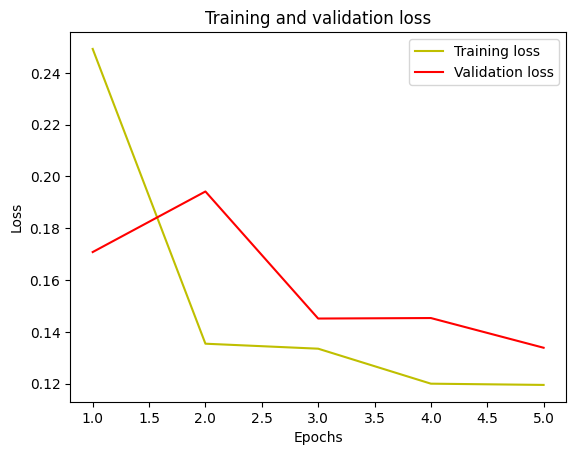

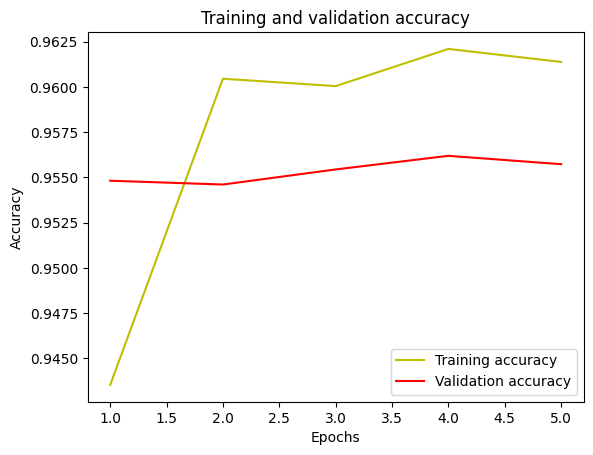

In [34]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
plt.savefig('5epoch_unet_fıltresız.png')

<Figure size 640x480 with 0 Axes>